<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/figS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies


In [82]:
import time
t1 = time.time()

In [83]:
## uncomment this cell if run in colab ##

%%capture
!pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git
!pip install scanpy umap-learn

# !git clone https://github.com/pachterlab/GFCP_2021.git
# !cd GFCP_2021
from vis import * 

In [84]:
## run locally ##
# %cd ../../GFCP_2021
# from vis import * 
# %cd notebooks

In [85]:
from os.path import exists

plt.rcParams.update({'font.size': 22})

# Simulations

Generate or load simulation data

In [86]:
!mkdir -p data

In [87]:
nCells,nGenes,T,tau,topo =  2000,100,10,[0,3,7],"aba"
meta = nCells,nGenes,T,tau,topo
filename="data/simdata_aba"

if not exists(filename):
    simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo,seed=42)
    sim_export(simdata,meta,filename)
vlm = vcy.VelocytoLoom(loom_filepath=filename+'.loom')

preprocess(vlm,sim=True,meta=meta,filter=False,sz_normalize=False)

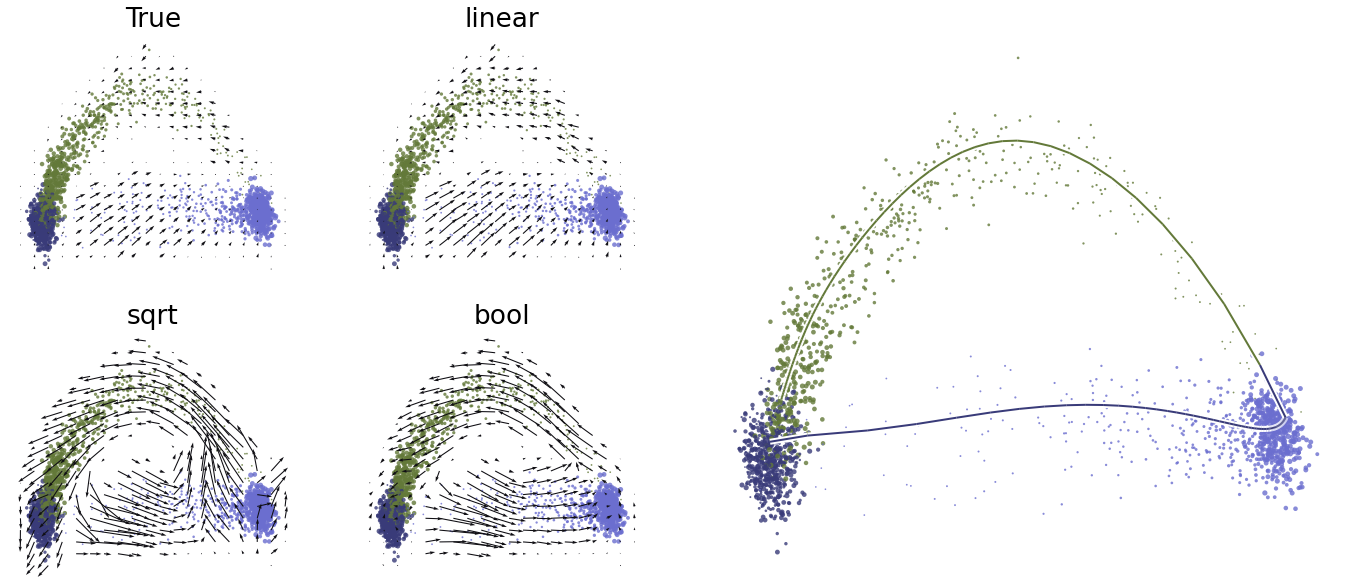

In [88]:
fig = plt.figure(figsize=(24,10))
ax0 = plt.subplot2grid((2, 4), (0, 0))
ax1 = plt.subplot2grid((2, 4), (0, 1))
ax2 = plt.subplot2grid((2, 4), (1, 0))
ax3 = plt.subplot2grid((2, 4), (1, 1))
ax4 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)

steps = (20,20)

axs=[ax2,ax3]

Trans = ["sqrt","bool"]
quiver_scale=10
#fig2, ax2 = plt.subplots(1, len(Trans),figsize=(len(Trans)*6,4))
arrows=[]

vlm.embedding=vlm.pcs

vlm.delta_embedding=linear_embed(vlm, True_gammas=True)
arrows.append(vlm.delta_embedding)
vlm.calculate_grid_arrows(smooth=0.5, steps=steps, n_neighbors=100)
plotEmbed(ax0,vlm,'pcs',sim=True)
plotGrid(ax0,vlm,"flow_grid","flow", "True", scale=quiver_scale/2, c=vermeer[7])
ax0.set_title("True")
ax0.axis('off')

getImputed(vlm, knn_k=50) #Sx_sz
vlm.delta_embedding=linear_embed(vlm)
arrows.append(vlm.delta_embedding)
vlm.calculate_grid_arrows(smooth=0.5, steps=steps, n_neighbors=100)
plotEmbed(ax1,vlm,'pcs',sim=True)
plotGrid(ax1,vlm,"flow_grid","flow", "linear", scale=quiver_scale/2, c=vermeer[7])
ax1.set_title("linear")
ax1.axis('off')

for i,trans in enumerate(Trans):
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="pcs", transform=trans,
                            n_neighbors=150, knn_random=False, sampled_fraction=1)

    if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
        warnings.warn("Nan values in corrcoef, setting them to 0")
        vlm.corrcoef[np.isnan(vlm.corrcoef)]=0

    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
    vlm.calculate_grid_arrows(smooth=0.5, steps=steps, n_neighbors=100)
    
    arrows.append(vlm.delta_embedding)
    plotEmbed(axs[i],vlm,'pcs',sim=True)
    plotGrid(axs[i],vlm,"flow_grid","flow", trans, scale=quiver_scale, c=vermeer[7])

 
    #ax.legend(loc='upper right') #bbox_to_anchor=(1.05, 1.0),
    axs[i].set_title(trans)
    axs[i].axis('off')


plotEmbed(ax4, vlm, "pcs", sim=True)
colorbytime=True
seg = princCurvePlots(ax4,vlm,meta,colorbytime)
ax4.axis('off')
plt.show()

In [89]:
!mkdir -p figure

In [91]:
fig.savefig('figure/aba_embed.png',dpi=600)

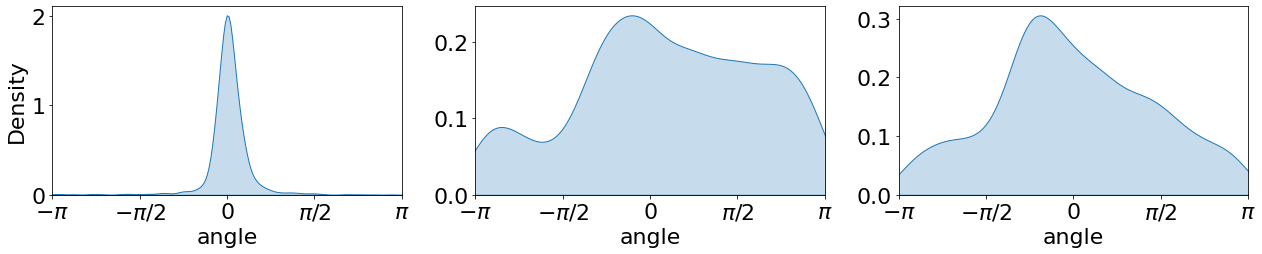

In [92]:
fig, ax = plt.subplots(1,3, figsize = (18,4))
baseline_arrow = arrows[0]
for i in range(3):
    arrow=arrows[i+1]
    plotTheta(ax[i], baseline_arrow, arrow, k=None)

ax[1].set(ylabel=None)
ax[2].set(ylabel=None)
fig.tight_layout()

In [93]:
fig.savefig('figure/aba_angle.png',dpi=600)

In [94]:
t2 = time.time()

In [95]:
print('Runtime: {:.2f} seconds.'.format(t2-t1))

Runtime: 99.09 seconds.


In [97]:
!zip figures.zip figure/*

  adding: figure/aba_angle.png (deflated 24%)
  adding: figure/aba_embed.png (deflated 8%)
  adding: figure/figure_S2_angle.png (deflated 24%)
  adding: figure/figure_S2.png (deflated 99%)
